In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import math
import torch.nn as nn

from typing import Tuple, List
from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from PIL import Image
import torch

### Load the paths of preprocessed images and masks

In [3]:
mask_paths = "/kaggle/input/hubmap-preprocessing/masks/*"
image_paths = "/kaggle/input/hubmap-preprocessing/images/*"

mask_paths = glob(mask_paths)
image_paths = glob(image_paths)

#### Visualization example

In [4]:
example_image_id = "29143"
example_mask_paths = []
example_image_paths = []

for mask_path in mask_paths:
    if example_image_id in mask_path.split("/")[-1]:
        example_mask_paths.append(mask_path)
        
for image_path in image_paths:
    if example_image_id in image_path.split("/")[-1]:
        example_image_paths.append(image_path)
        
num_tiles = max([int(example_mask_path.split("/")[-1].split("_")[1].split(".")[0]) for example_mask_path in example_mask_paths]) + 1
example_mask_paths = sorted(example_mask_paths, key=lambda x: int(x.split("/")[-1].split("_")[1].split(".")[0]))
example_image_paths = sorted(example_image_paths, key=lambda x: int(x.split("/")[-1].split("_")[1].split(".")[0]))

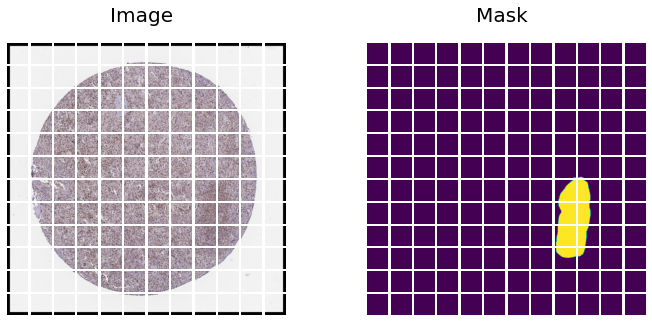

In [5]:
example_mask_paths = []
example_image_paths = []

for mask_path in mask_paths:
    if example_image_id in mask_path.split("/")[-1]:
        example_mask_paths.append(mask_path)
        
for image_path in image_paths:
    if example_image_id in image_path.split("/")[-1]:
        example_image_paths.append(image_path)
        
num_tiles = max([int(example_mask_path.split("/")[-1].split("_")[1].split(".")[0]) for example_mask_path in example_mask_paths]) + 1

# sort the image tile paths and mask tile paths
example_mask_paths = sorted(example_mask_paths, key=lambda x: int(x.split("/")[-1].split("_")[1].split(".")[0]))
example_image_paths = sorted(example_image_paths, key=lambda x: int(x.split("/")[-1].split("_")[1].split(".")[0]))

# visualize the image and the corresponding mask,
# with subplots in subfigures
fig = plt.figure(figsize=(10,5))
subfigs = fig.subfigures(1, 2)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

images_per_row_col = int(num_tiles ** 0.5)

for (subfig, label, subfigure) in zip(subfigs.flat, ["Image", "Mask"], [example_image_paths, example_mask_paths]):
    subfig.suptitle(label, fontsize=20)
    axs = subfig.subplots(images_per_row_col, images_per_row_col)
    k = 0
    for i in range(images_per_row_col):
        for j in range(images_per_row_col):
            img = Image.open(subfigure[k])
            axs[i,j].imshow(img, vmin=0, vmax=1)
            axs[i,j].axis('off')
            k += 1

### Define the Model

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, filters: List, img_channels: int, kernel_size: int, padding: int):
        """Initialize all layers for the Encoder.
        
        Args:
            filters: a list of ints for the number of filters
            img_channels: 3 (rgba) or 1 (grayscale)
            kernel_size: a kernel of size (kernel_size x kernel_size)
            padding: amount of pixels per side to pad (zeros by default)
        """   
        
        super().__init__()
               
        self.contract_blocks = nn.ModuleList()
        previous_size = img_channels
        
        for i, filter_size in enumerate(filters[:-1]):
            conv1 = nn.Conv2d(previous_size, filter_size, kernel_size, padding=padding, bias=False)
            conv2 = nn.Conv2d(filter_size, filter_size, kernel_size, padding=padding, bias=False)
            pool = nn.MaxPool2d(2) # 2 = kernel size and stride
            relu = nn.ReLU(inplace=True)
            batchnorm = nn.BatchNorm2d(filter_size)
            
            # i want to concatenate featueres from the last conv layer (prior to performing max pool),
            # thus in the first iteration the sub_block looks different
            if i == 0:
                sub_block = [conv1, batchnorm, relu, conv2, batchnorm, relu]
            else:
                sub_block = [pool, conv1, batchnorm, relu, conv2, batchnorm, relu]
                                
            sub_block = nn.Sequential(*sub_block)
            self.contract_blocks.append(sub_block)
            
            previous_size = filter_size
            
        
    def forward(self, x: torch.Tensor) -> Tuple[List, torch.Tensor]:
        """Run the input through the encoder block.
        
        Args:
            x: input image/tile
            
        Returns:
            x_contract: list of tensors
            x: tensor from the last contraction block
        """
        
        x_contract = []
        
        # iterate over each contract block 
        for contract_block in self.contract_blocks:
            x_contracted = contract_block(x)
            x_contract.append(x_contracted)
            x = x_contracted

        return x_contract, x
        
        
        
class Decoder(nn.Module):
    
    def __init__(self, filters: List, depth: int, kernel_size: int, padding: int, deconv_kernel_size: int, deconv_stride: int):
        """Initialize all layers for the Decoder.
        
        Args:
            filters: a list of ints for the number of filters
            depth: the depth of the UNet network (= number of max pool layers)
            kernel_size: a kernel of size (kernel_size x kernel_size)
            padding: amount of pixels per side to pad (zeros by default)
            deconv_kernel_size: a kernel of size (deconv_kernel_size x deconv_kernel_size) for the transpose convolution
            deconv_stride: the stride for the applied kernel in the transpose convolution layer
        """   
        
        super().__init__()
        
        self.depth = depth
        self.expand_blocks = nn.ModuleList()
        previous_size = filters[-1]
        
        for filter_size in reversed(filters[:-1]):
        
            up = nn.ConvTranspose2d(previous_size, filter_size, kernel_size=deconv_kernel_size, stride=deconv_stride)
            
            conv1 = nn.Conv2d(previous_size, filter_size, kernel_size, padding=padding, bias=False)
            conv2 = nn.Conv2d(filter_size, filter_size, kernel_size, padding=padding, bias=False)
            relu = nn.ReLU(inplace=True)
            batchnorm = nn.BatchNorm2d(filter_size)

            conv_block = [conv1, batchnorm, relu, conv2, batchnorm, relu]
            modules = nn.ModuleList([up, nn.Sequential(*conv_block)])
            
            self.expand_blocks.append(modules)
            
            previous_size = filter_size
            
                        
    def forward(self, x: torch.Tensor, contract_blocks: List) -> torch.Tensor:
        """Perform the decoding and concatenating.
        
        Args:
            x: output from the bottom path
            contract_blocks: a List of torch.Tensors
            
        Returns:
            x: output from the Decoder
        """
        
        for i, expand_block in enumerate(self.expand_blocks):
            # do ConvTranspose2d (i.e. up convolution)
            x_expanded = expand_block[0](x)
            
            # concatenate it with features from the contract path on the channel dimension (axis=1)
            x_expanded = torch.cat((contract_blocks[self.depth - (i+1)], x_expanded), axis=1)
            
            # convolve on concatenated features
            x = expand_block[1](x_expanded)
        
        return x
    
    
class UNet(nn.Module):
    
    def __init__(self, 
                 n_classes: int,
                 img_channels: int, 
                 start_filter: int, 
                 depth: int,
                 kernel_size: int = 3,
                 padding: int = 1,
                 deconv_kernel_size: int = 2,  
                 deconv_stride: int = 2,
                 ):   
        """Initialize all layers for the UNet.
        
        Args:
            n_classes: number of classes
            img_channels: 3 (rgba) or 1 (grayscale)
            start_filter: starting filter size
            depth: the depth of the UNet network (= number of max pool layers)
            kernel_size: a kernel of size (kernel_size x kernel_size)
            padding: amount of pixels per side to pad (zeros by default)
            deconv_kernel_size: a kernel of size (deconv_kernel_size x deconv_kernel_size) for the transpose convolution
            deconv_stride: the stride for the applied kernel in the transpose convolution layer
        """   
    
        super().__init__()
        
        self.n_classes = n_classes
        self.start_filter = start_filter
        self.depth = depth
        self.kernel_size = kernel_size
        self.padding = padding
        
        self.filters = [start_filter*(2**i) for i in range(depth+1)]
        
        self.encoder = Encoder(self.filters, img_channels, kernel_size, padding)
        self.bottom_path = self._bottom_path()
        self.decoder = Decoder(self.filters, depth, kernel_size, padding, deconv_kernel_size, deconv_stride)
        
        self.output = nn.Conv2d(
            self.filters[0],
            self.n_classes,
            kernel_size=1
        )
    
    def _bottom_path(self) -> nn.Sequential():
        """Define the layers for the bottom path.
        
        Returns:
            bottom_path_layers: a sequential container
        """
        
        # set the bottom path
        pool = nn.MaxPool2d(2) # 2 = kernel size and stride
        conv1 = nn.Conv2d(self.filters[-2], self.filters[-1], self.kernel_size, padding=self.padding, bias=False)
        conv2 = nn.Conv2d(self.filters[-1], self.filters[-1], self.kernel_size, padding=self.padding, bias=False)
        relu = nn.ReLU(inplace=True)
        batchnorm = nn.BatchNorm2d(self.filters[-1])
        
        bottom_path_layers = nn.Sequential(pool, conv1, batchnorm, relu, conv2, batchnorm, relu)
        
        return bottom_path_layers
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Run the input image through the UNet.
        
        Args:
            x: input image/tile
            
        Returns:
            torch.Tensor: the final prediction mask
        """
        
        # encode
        contract_blocks, x = self.encoder(x)
        
        # run through the bottom path
        x = self.bottom_path(x)
        
        # decode
        x = self.decoder(x, contract_blocks)
        
        # output layer
        y_pred = self.output(x)
    
        return torch.sigmoid(y_pred)

In [8]:
def rle_to_mask(rle: str, img_width: int, img_height: int):
    """Generate the mask for a given image.

    Args:
        rle: the run length encoded image
        img_width: width of an image
        img_height: height of the image

    Returns:
        np.array: the image array with labels    
    """
    
    rle = rle.split()
    
    # split the list into start indices and length 
    starts, lengths = list((np.array(rle, dtype=int)[::2], np.array(rle, dtype=int)[1::2]))
    
    # create start and end indices 
    starts -= 1
    ends = starts + lengths
    
    # create a vector of zeros 
    img = np.zeros(img_height*img_width, dtype=np.uint8)
    
    # populate the vector
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    # return the mask
    return img.reshape((img_height, img_width)).T

### Define the Dataloader

In [9]:
# Use this Dataloader, when generating the mask on the fly

# from torch.utils.data import Dataset, DataLoader

# class Dataset(Dataset):
#     def __init__(self, df):
#         super().__init__()

#         self.df = df
        
#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
        
#         img_path = self.df.train_image_path.iloc[idx]
#         rle = self.df.rle.iloc[idx]
        
#         image = np.asarray(Image.open(img_path)).astype(np.float32)
#         mask = rle_to_mask(rle, self.df.img_width.iloc[idx], self.df.img_height.iloc[idx]).astype(np.float32)
        
        
#         return [torch.Tensor(np.moveaxis(image, 2, 0)), torch.Tensor(mask[np.newaxis,...]), self.df.train_annotation_path[idx]]

# data_train = Dataset(train_csv)
# data_train_loader = DataLoader(data_train, batch_size=1, shuffle=True)

In [10]:
# Use this Dataloader, when using the preprocessed masks!

from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, mask_paths: List, image_paths: List):
        """Initialize a Dataset.
        
        Args:
            mask_paths: a list of paths for masks
            image_paths: a list of paths for images/tiles
        """
        
        super().__init__()

        self.mask_paths = mask_paths
        self.image_paths = image_paths
        
    def __len__(self) -> int:
        return len(self.mask_paths)

    def __getitem__(self, idx: int) -> List:
        
        # open the images, turn them into arrays, and set the channel dimension as the first dimension
        image = np.moveaxis(np.asarray(Image.open(self.image_paths[idx])) / 255, 2, 0)
        mask = np.asarray(Image.open(self.mask_paths[idx])) / 255
        
        return [torch.Tensor(image), torch.Tensor(mask[np.newaxis,...])]

data_train = Dataset(mask_paths, image_paths)
# for debugging
#data_train = Dataset(['/kaggle/input/hubmap-preprocessing/masks/16728_56.png'], ['/kaggle/input/hubmap-preprocessing/images/16728_56.png'])

data_train_loader = DataLoader(data_train, batch_size=8, shuffle=True)

### Custom Loss and training preparation

In [11]:
def dice_loss(predicted_mask, true_mask, eps=1e-8) -> torch.Tensor:
    """Compute the dice loss for a given mask.
    The Dice loss is computed with probabilities, instead of discrete values,
    to make it differentiable. Compute the dice loss for each smaple individually,
    and then take the mean.
    
    Args:   
        predicted_mask: predicted mask
        true_mask: the actual mask
    
    Return:
        torch.Tensor: the loss (1 - dice score)
    """

    # flatten the predicted mask and the true mask
    batch_dim = predicted_mask.shape[0]
    predicted_mask = predicted_mask.view(batch_dim, -1)
    true_mask = true_mask.view(batch_dim, -1)
    
    intersection = (predicted_mask * true_mask).sum(1)
    dice = (2 * intersection) / (predicted_mask.sum(1) + true_mask.sum(1) + eps)
    dice = dice.sum() / batch_dim
    
    # the dice score is between 0 (worst prediction) and 1 (perfect prediction),
    # so the expression 1 - dice will be minimized
    return 1 - dice

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model = UNet(n_classes=1, img_channels=3, start_filter=32, depth=4) # for my model
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())
epochs = 20

### Training loop

In [14]:
for epoch in tqdm(range(epochs)):
    
    train_epoch_loss = 0

    for img, mask in data_train_loader:

        # zero the parameter gradients
        optimizer.zero_grad()
        img, mask = img.to(device), mask.to(device)
        
        # forward pass
        y_pred = model(img)        

        # backward pass
        loss = dice_loss(y_pred.to(device), mask.to(device))
        loss.backward()
        
        # optimize
        optimizer.step()

        train_epoch_loss += loss.item()


    print("EPOCH LOSS:", train_epoch_loss)
    
#save the model
torch.save(model.state_dict(), 'unet_baseline.pt')

  5%|▌         | 1/20 [24:59<7:54:59, 1499.98s/it]

EPOCH LOSS: 6241.880831003189


 10%|█         | 2/20 [41:10<5:56:28, 1188.27s/it]

EPOCH LOSS: 6241.254914343357


 15%|█▌        | 3/20 [57:52<5:12:40, 1103.56s/it]

EPOCH LOSS: 6240.793954253197


 20%|██        | 4/20 [1:13:59<4:39:51, 1049.46s/it]

EPOCH LOSS: 6240.554290831089


 25%|██▌       | 5/20 [1:30:01<4:14:31, 1018.11s/it]

EPOCH LOSS: 6240.3940396904945


 30%|███       | 6/20 [1:46:07<3:53:24, 1000.34s/it]

EPOCH LOSS: 6240.242834150791


 35%|███▌      | 7/20 [2:02:08<3:33:57, 987.53s/it] 

EPOCH LOSS: 6240.127739310265


 40%|████      | 8/20 [2:18:08<3:15:44, 978.68s/it]

EPOCH LOSS: 6240.026498258114


 45%|████▌     | 9/20 [2:34:08<2:58:21, 972.87s/it]

EPOCH LOSS: 6239.899938583374


 50%|█████     | 10/20 [2:50:08<2:41:27, 968.70s/it]

EPOCH LOSS: 6239.826018869877


 55%|█████▌    | 11/20 [3:06:06<2:24:49, 965.48s/it]

EPOCH LOSS: 6239.758066773415


 60%|██████    | 12/20 [3:22:07<2:08:33, 964.15s/it]

EPOCH LOSS: 6239.684684991837


 65%|██████▌   | 13/20 [3:38:06<1:52:17, 962.55s/it]

EPOCH LOSS: 6239.635735571384


 70%|███████   | 14/20 [3:54:07<1:36:13, 962.21s/it]

EPOCH LOSS: 6239.579261302948


 75%|███████▌  | 15/20 [4:10:09<1:20:10, 962.02s/it]

EPOCH LOSS: 6239.5553178191185


 80%|████████  | 16/20 [4:26:09<1:04:06, 961.56s/it]

EPOCH LOSS: 6239.466059625149


 85%|████████▌ | 17/20 [4:42:10<48:04, 961.42s/it]  

EPOCH LOSS: 6239.4395144581795


 90%|█████████ | 18/20 [4:58:12<32:03, 961.56s/it]

EPOCH LOSS: 6239.442868709564


 95%|█████████▌| 19/20 [5:14:14<16:01, 961.76s/it]

EPOCH LOSS: 6239.3784356713295


100%|██████████| 20/20 [5:30:18<00:00, 990.92s/it]

EPOCH LOSS: 6239.311495184898


### Test on image

In [ ]:
# Adapted from: https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode/script

def mask_to_rle(img: np.array) -> str:
    """Get the run length encoding for a given segmented image/mask.

    Args:
        img_array: the run length encoded string

    Returns:
        str: the run length encoded representation of a segmented image
    """
    
    # transpose and flatten the image
    pixels = img.T.flatten()
    
    # add zeros at the start and beginning of the vector
    pixels = np.concatenate([[0], pixels, [0]])
    
    # capture the changes, i.e. where does a 1 start and where does it end
    # add a 1 since the rle starts from 1 and not 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    
    # subtract every second value from its previous value (to get the length)
    runs[1::2] -= runs[::2]
    
    # return a string representation, without square brackets
    return str(runs)[1:-1]

In [ ]:
def generate_tiles(img_path: str, padding_mode: str, tile_size: int) -> Tuple[List, List]:
    """Generate tiles for a given image and mask.
    
    Args:
        img_path: path of the image file
        padding_mode: how to pad, e.g. "constant"
        tile_size: the size of the tiles
        
    Returns:
        test_tiles_for_visualization: list of numpy array tiles for visualization
        test_tiles_for_training: list of torch.Tensor tiles for testing
    """    
    
    img = np.asarray(Image.open(img_path))
            
    if img.shape[1] % 2 != 0: # pad if the height/width has an uneven number of pixel
        img = np.pad(img, ((1,0), (1,0), (0,0)), padding_mode) # pad first row and first column with a single row/column of zeros
        
    excess_pixels = img.shape[0] % tile_size
    pixels_to_pad_per_side = int((tile_size - excess_pixels) / 2)
    img = np.pad(img, ((pixels_to_pad_per_side,pixels_to_pad_per_side),(pixels_to_pad_per_side,pixels_to_pad_per_side),(0,0)), padding_mode) # pad first row and first column
    
    test_tiles_for_visualization = []
    test_tiles_for_training = []
    
    k = 0
    for i in range(0, len(img), tile_size):
        for j in range(0, len(img), tile_size):

            img_temp = img[i:i+tile_size, j:j+tile_size, :] / 255
            
            test_tiles_for_visualization.append(img_temp)
            
            img_temp = torch.Tensor(np.moveaxis(img_temp, 2, 0)[np.newaxis,...])
            
            test_tiles_for_training.append(img_temp)
            
            k += 1
                    
    return test_tiles_for_visualization, test_tiles_for_training

In [ ]:
def postprocess(prediction_tiles: list, tile_size: int, img_size: int) -> np.array:
    """Stich together the masks that are predicted,
    and remove the padding.
    
    Args:
        prediction_tiles: a list of masks
        tile_size: the size of the tiles 
        img_size: original size of the image
        
    Returns:
        predicted_mask: stitched image
    """
    
    images_per_row = int(len(prediction_tiles) ** 0.5)
    stitched_prediction_mask = np.array([[]])

    # Predicted mask
    for index, prediction in enumerate(prediction_tiles):
        if index % images_per_row == 0: # if it is the first image in the row
            full_row = prediction

        elif index % images_per_row > 0 and index % images_per_row < images_per_row: # if it is not the first image in a row
            full_row = np.concatenate((full_row, prediction), axis = 1)

            if index % images_per_row == images_per_row - 1: # if it is the last image in a row
                if stitched_prediction_mask.size == 0:
                    stitched_prediction_mask = full_row
                else:
                    stitched_prediction_mask = np.concatenate((stitched_prediction_mask, full_row), axis = 0)

    total_padding = stitched_prediction_mask.shape[0] - img_size
    padding_per_side = int(total_padding/2)
    predicted_mask = stitched_prediction_mask[padding_per_side:len(stitched_prediction_mask)-padding_per_side, 
                                              padding_per_side:len(stitched_prediction_mask)-padding_per_side]

    if total_padding % padding_per_side == 1:
        # ignore first row and first column if the original image size has uneven height and width
        predicted_mask = predicted_mask[1:, 1:]
    
    return predicted_mask

In [ ]:
df_test = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
ids, preds = [], []

tile_size = 256
padding_mode = "constant"

def predict(tiles: List) -> List:
    """Predict on the given tiles.
    
    Args:
        tiles: list of torch.Tensor tiles for testing
        
    Returns:
        prediction_tiles: list of numpy of arrays of predicted masks 
    """

    prediction_tiles = []

    # test loop, deactivate gradiant calculation
    with torch.no_grad():
        for img in test_tiles_for_training:

            # predict (i.e. use only the forward pass of the model)
            y_pred = model(img.to(device))

            # generate the mask
            mask = (y_pred > 0.5).type(torch.uint8)[0,0,:,:].cpu().numpy()

            # append to all predictions
            prediction_tiles.append(mask)
            
    return prediction_tiles

# iterate over the test dataframe
for row in df_test.itertuples():
    ids.append(row.id)
    
    test_image_path = f"/kaggle/input/hubmap-organ-segmentation/test_images/{row.id}.tiff"
    
    test_tiles_for_visualization, test_tiles_for_training = generate_tiles(test_image_path, padding_mode, tile_size)

    prediction_tiles = predict(test_tiles_for_training)
    
    predicted_mask = postprocess(prediction_tiles, tile_size, row.img_height)
    
    rle_encoded_mask = mask_to_rle(predicted_mask)
    
    preds.append(rle_encoded_mask)

In [ ]:
# Submit predictions
submission_df = pd.DataFrame({"id": ids, "rle": preds})
submission_df.to_csv("submission.csv", index=False)